In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Convolutional Neural Network (CNN)

- neural network for processing images (mostly)

- consists of convolutional layers, maxpooling layers and standard dense, fully connected layers

- idea is to scale down images using convolutional and maxpooling layers without losing too much information

- once an image has been scaled and transformed to lower dimensions it can be passed to fully connected layers 

![CNN](../img/conv.png)

# Convolution

- operation from the field of digital signal processing

- 2D convolution uses two matrices, input and kernel, to produce some output

- a kernel matrix is slid over the input matrix, doing element-wise multiplication and summing

- kernel can be thought of as a filter, and the result of the operation is a filtered image

- depending on the kernel, there are many use cases: 
    - blurring
    - smoothing
    - edge detection
    - sharpening
    - feature detection
    - noise reduction

# Valid convolution animation

![ValidConvolution](../img/conv_valid.gif)

# Full convolution animation

![FullConvolution](../img/conv_full.gif)

# Valid vs. full convolution

- **valid**
    - kernel is slid within borders of the input matrix
    - kernel and input overlap completely
    - output matrix is smaller in size compared to input matrix

- **full**
    - kernel is slid outside the borders of the input matrix
    - kernel and input overlap partially at borders
    - region outside of borders is padded with zeros
    - output is larger in size compared to input matrix

# Cross Correlation vs. Convolution

- Cross Correlation is sliding a kernel over the input matrix (denoted using $\star$ symbol)

- Convolution is sliding a *180 degrees rotated* kernel over the input matrix (denoted using $\ast$ symbol)

- this subtle difference is observed in backpropagation of the convolutional layer

- Cross Correlation is used primarily in equations and code throughout this notebook, but the same can be achieved with Convolution with minor changes

# Stride

- step size of kernel when sliding over the input matrix

- affects output size

![Stride](../img/conv_stride.gif)

# Output size formula (for square matrices)

- $ \text{valid} = \lfloor \frac{\text{input size} - \text{kernel size} + 2 \cdot \text{padding}}{\text{stride}} \rfloor + 1$

- $\text{full} = \lfloor \frac{\text{input size} + \text{kernel size} + 2 \cdot \text{padding}}{\text{stride}} \rfloor - 1$

- $\lfloor \rfloor$ denotes the floor function

# Forward propagation for convolutional layer

- input matrix $\mathbf{X}$

- kernel matrix $\mathbf{k}$

- output matrix $\mathbf{Y}$

$$\mathbf{Y} = \mathbf{X} \star_{\text{valid}} \mathbf{k}$$

# Backward propagation for convolutional layer

- accumulated gradient from other layers $\delta$

- gradient of the loss function $\mathcal{L}$ with respect to input matrix $\frac{\partial \mathcal{L}}{\partial \mathbf{X}}$

- gradient of the loss function $\mathcal{L}$ with respect to kernel $\frac{\partial \mathcal{L}}{\partial \mathbf{k}}$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{X}} = \delta \ast_{\text{full}} \mathbf{k} \quad \quad \frac{\partial \mathcal{L}}{\partial \mathbf{k}} = \mathbf{X} \star_{\text{valid}} \delta $$

- if stride greater than 1 is present, $\delta$ needs to be dilated and padded to match shape

# Dilation

- inserting zeroes between consecutive elements

- used for pixel skipping, just like stride skips pixels

- $\text{stride} - 1$ zeroes are inserted between elements

![Dilation](../img/conv_dilate.webp)

# Convolution implementation

In [24]:
from typing import Literal

def convolve2d(matrix: np.ndarray, kernel: np.ndarray, mode: Literal['valid', 'full'] = 'valid') -> np.ndarray:
    """
    Function for convolving 2D input array.

    Parameters
    ----------
    matrix : np.ndarray
        Input array.

    kernel : np.ndarray
        Array which slides over the input array.

    Returns
    -------
    output : np.ndarray
        Result of convolution.
    """
    # Get the dimensions of the input matrix and kernel
    m, n = matrix.shape
    km, kn = kernel.shape

    # Flip the kernel for convolution
    kernel_flipped = np.rot90(kernel, 2) # or kernel_flipped = np.flipud(np.fliplr(kernel))

    if mode == 'valid':
    
        # Calculate the dimensions of the output matrix
        output_dim_m = m - km + 1
        output_dim_n = n - kn + 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Perform the convolution
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel_flipped)
    
    elif mode == 'full':

        # Calculate the dimensions of the output matrix
        output_dim_m = m + km - 1
        output_dim_n = n + kn - 1
        output = np.zeros((output_dim_m, output_dim_n))

        # Pad input matrix with zeros
        padded_matrix = np.pad(matrix, ((km - 1, km - 1), (kn - 1, kn - 1)), mode='constant')

        for i in range(output_dim_m):
            for j in range(output_dim_n):
                region = padded_matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel_flipped)

    return output

# Valid convolution example

In [25]:
x = np.array([[3, 1, 0, 2, 5, 6],
              [4, 2, 1, 1, 4 ,7],
              [5, 4 ,0, 0, 1, 2],
              [1, 2, 2, 1, 3, 4],
              [6, 3, 1, 0, 5, 2],
              [3, 1, 0, 1, 3, 3]])

kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])

y = convolve2d(x, kernel, mode='valid')
# It is noticable that the rotation of kernel from convolution does not yield the same result as the first animation
print(y)

[[ 11.   4.  -9. -12.]
 [  7.   6.  -5. -11.]
 [  9.   8.  -6.  -7.]
 [  7.   4.  -8.  -7.]]


# Full convolution example

In [26]:
x = np.array([[3, 1, 0, 2, 5, 6],
              [4, 2, 1, 1, 4 ,7],
              [5, 4 ,0, 0, 1, 2],
              [1, 2, 2, 1, 3, 4],
              [6, 3, 1, 0, 5, 2],
              [3, 1, 0, 1, 3, 3]])

kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])

y = convolve2d(x, kernel, mode='full')
print(y)

[[ -3.  -1.   3.  -1.  -5.  -4.   5.   6.]
 [ -7.  -3.   6.   0.  -8. -10.   9.  13.]
 [-12.  -7.  11.   4.  -9. -12.  10.  15.]
 [-10.  -8.   7.   6.  -5. -11.   8.  13.]
 [-12.  -9.   9.   8.  -6.  -7.   9.   8.]
 [-10.  -6.   7.   4.  -8.  -7.  11.   9.]
 [ -9.  -4.   8.   3.  -7.  -4.   8.   5.]
 [ -3.  -1.   3.   0.  -3.  -2.   3.   3.]]


# Cross correlation implementation

In [27]:
def cross_correlate2d(matrix: np.ndarray, kernel: np.ndarray, mode: Literal['valid', 'full'] = 'valid') -> np.ndarray:
    """
    Function for cross correlating 2D input array.

    Parameters
    ----------
    matrix : np.ndarray
        Input array.

    kernel : np.ndarray
        Array which slides over the input array.

    Returns
    -------
    output : np.ndarray
        Result of cross correlation.
    """
    # Get the dimensions of the input matrix and kernel
    m, n = matrix.shape
    km, kn = kernel.shape

    if mode == 'valid':
        
        # Calculate the dimensions of the output matrix
        output_dim_m = m - km + 1
        output_dim_n = n - kn + 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Perform the cross-correlation
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel)
        
        return output
    
    elif mode == 'full':
        
        # Calculate the dimensions of the output matrix
        output_dim_m = m + km - 1
        output_dim_n = n + kn - 1
        output = np.zeros((output_dim_m, output_dim_n))
        
        # Pad the input matrix with zeros
        padded_matrix = np.pad(matrix, ((km-1, km-1), (kn-1, kn-1)), mode='constant')

        # Perform the cross-correlation
        for i in range(output_dim_m):
            for j in range(output_dim_n):
                # Element-wise multiplication and summation
                region = padded_matrix[i:i+km, j:j+kn]
                output[i, j] = np.sum(region * kernel)
        
    return output

# Valid cross correlation example

In [28]:
x = np.array([[3, 1, 0, 2, 5, 6],
              [4, 2, 1, 1, 4 ,7],
              [5, 4 ,0, 0, 1, 2],
              [1, 2, 2, 1, 3, 4],
              [6, 3, 1, 0, 5, 2],
              [3, 1, 0, 1, 3, 3]])

kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])

y = cross_correlate2d(x, kernel, mode='valid')
# Using cross correlation which does not rotate the kernel yields the same result as the first animation
print(y)

[[-11.  -4.   9.  12.]
 [ -7.  -6.   5.  11.]
 [ -9.  -8.   6.   7.]
 [ -7.  -4.   8.   7.]]


In [29]:
def dilate(arr: np.ndarray, stride: int) -> np.ndarray:
    """
    Expands boundaries of an array by adding rows and columns of zeros between array elements.

    Parameters
    ----------
    arr : np.ndarray
        Array to dilate.

    stride : int
        Number of zeroes added between a pair of elements.
        NOTE: stride - 1 zeros are added between elements.

    Returns
    -------
    dilated_arr : np.ndarray
    """
    # Create a new array with appropriate size for dilation
    dilated_shape = (arr.shape[0] - 1) * stride + 1, (arr.shape[1] - 1) * stride + 1
    dilated = np.zeros(dilated_shape)
    
    # Place the original array elements into the dilated array
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            dilated[i * stride, j * stride] = arr[i, j]
    
    return dilated

def pad_to_shape(arr: np.ndarray, target_shape: tuple) -> np.ndarray:
    """
    Adds padding to array so it matches target shape.

    Parameters
    ----------
    arr : np.ndarray
        Array to pad.

    target_shape : tuple
        Shape of the array after padding.

    Returns
    -------
    padded_arr : np.ndarray
    """
    # Calculate padding needed
    pad_height = target_shape[0] - arr.shape[0]
    pad_width = target_shape[1] - arr.shape[1]
    
    if pad_height < 0 or pad_width < 0:
        raise ValueError("Target shape must be larger than the array shape.")
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Apply padding
    padded = np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return padded

# Dilate and pad example

In [30]:
x = np.array([[1, 2],
              [3, 4]])

dilated = dilate(x, 2)
print(f'Dilated:\n{dilated}')

dilated_padded = pad_to_shape(dilated, (5, 5))
print(f'Dilated and padded:\n{dilated_padded}')

Dilated:
[[1. 0. 2.]
 [0. 0. 0.]
 [3. 0. 4.]]
Dilated and padded:
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 3. 0. 4. 0.]
 [0. 0. 0. 0. 0.]]


# Convolutional layer

In [31]:
from dlfs.base import Layer

class ConvolutionalLayer(Layer):

    def __init__(self, input_shape: tuple, output_channels: int, kernel_size: int, stride: int = 1, padding: int = 0) -> None:
        """
        Convolutional layer.

        Parameters
        ----------
        input_shape : tuple
            Dimension of a single sample processed by the layer. For images it's (channels, width, height).

        output_channels : int
            Number of channels of the output array.

        kernel_size : int
            Dimension of a single kernel, square array of shape (kernel_size, kernel_size).

        stride : int, default=1
            Step size at which the kernel moves across the input.

        padding : int, default=0
            Amount of padding added to input.
        """
        # Unpack input_shape tuple
        input_channels, input_height, input_width = input_shape

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Calculate output width and height
        output_height = int((input_height - kernel_size + 2 * padding) / stride) + 1
        output_width = int((input_width - kernel_size + 2 * padding) / stride) + 1

        # Create output and kernel shapes
        self.output_shape = (output_channels, output_height, output_width)
        self.kernels_shape = (output_channels, input_channels, kernel_size, kernel_size)

        # Initialize layer parameters
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass using the convolutional layer. Creates output attribute.

        Parameters
        ----------
        inputs : numpy.ndarray
            Input matrix.

        Returns
        -------
        None
        """
        # Number of samples, first dimension
        n_samples = inputs.shape[0]

        # Store inputs for later use
        self.inputs = inputs

        # Output is 4D tensor of shape (n_samples, output_channels, height, width)
        self.output = np.zeros((n_samples, *self.output_shape))

        # Add bias to output
        self.output += self.biases

        # Loop through each sample, output channel and input channel
        for i in range(n_samples):
            for j in range(self.output_channels):
                for k in range(self.input_channels):
                    if self.padding:
                        inputs = np.pad(self.inputs[i, k], pad_width=self.padding, mode='constant')
                    else:
                        inputs = self.inputs[i, k].copy()
                    # Output is the cross correlation in valid mode between the input and kernel
                    self.output[i, j] += signal.correlate2d(inputs, self.kernels[j, k], mode="valid")[::self.stride, ::self.stride]

    def backward(self, delta: np.ndarray) -> None:
        """
        Backward pass using the convolutional layer. Creates gradient attributes with respect to kernels, biases and inputs.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        Returns
        -------
        None
        """
        # Initialize gradient attributes
        self.dkernels = np.zeros(self.kernels.shape)
        self.dbiases = np.zeros(self.biases.shape)
        self.dinputs = np.zeros(self.inputs.shape)

        # Number of samples, first dimension
        n_samples = self.inputs.shape[0]

        # Loop through each sample, output channel and input channel
        for i in range(n_samples):

            # Gradient with respect to biases is the sum of deltas
            self.dbiases += delta[i]

            for j in range(self.output_channels):
                for k in range(self.input_channels):

                    if self.padding:
                        
                        input_padded = np.pad(self.inputs[i, k], pad_width=self.padding)

                        dkernels = self._calculate_kernel_gradient(input_padded, delta[i, j], self.kernels[j, k], stride=self.stride)
                        dinputs = self._calculate_input_gradient(input_padded, delta[i, j], self.kernels[j, k], stride=self.stride)

                        # Since padding was used gradient needs to be unpadded to match shape
                        dinputs = dinputs[self.padding:-self.padding, self.padding:-self.padding]

                    else:
                        dkernels = self._calculate_kernel_gradient(self.inputs[i, k], delta[i, j], self.kernels[j, k], stride=self.stride)
                        dinputs = self._calculate_input_gradient(self.inputs[i, k], delta[i, j], self.kernels[j, k], stride=self.stride)

                    self.dkernels[j, k] += dkernels
                    self.dinputs[i, k] += dinputs

    def _calculate_kernel_gradient(self, inputs: np.ndarray, delta: np.ndarray, kernel: np.ndarray, stride: int = 1) -> np.ndarray:
        """
        Helper method for calculating kernel gradient.

        Parameters
        ----------
        inputs : np.ndarray
            Current sample the gradient is calculated for.

        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        kernel : np.ndarray
            Kernel used in convolutional layer.

        stride : int, default=1
            Step size at which the kernel moves across the input.

        Returns
        -------
        kernel_grad : np.ndarray
            Kernel gradient.
        """

        if stride > 1:

            # If stride is present delta needs to be dilated
            delta_dilated = dilate(delta, stride)

            delta_dilated_height, delta_dilated_width = delta_dilated.shape[-2:]
            input_height, input_width = inputs.shape[-2:]
            kernel_shape = kernel.shape[-1]

            if delta_dilated_height == input_height - kernel_shape + 1 and delta_dilated_width == input_width - kernel_shape + 1:
                # If dilated delta shape matches the needed correlation shape gradient can be computed
                dkernel = signal.correlate2d(inputs, delta_dilated, "valid")
            else:
                # If dilated delta shape doesn't match the needed correlation shape padding is needed
                new_delta_shape = (input_height - kernel_shape + 1, input_width - kernel_shape + 1)
                delta_dilated_padded = pad_to_shape(delta_dilated, new_delta_shape)
                dkernel = signal.correlate2d(inputs, delta_dilated_padded, "valid")

        else:
            # Gradient with respect to kernel is valid cross correlation between inputs and delta
            dkernel = signal.correlate2d(inputs, delta, "valid")

        return dkernel

    def _calculate_input_gradient(self, inputs: np.ndarray, delta: np.ndarray, kernel: np.ndarray, stride: int = 1):
        """
        Helper method for calculating input gradient.

        Parameters
        ----------
        inputs : np.ndarray
            Current sample the gradient is calculated for.

        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        kernel : np.ndarray
            Kernel used in convolutional layer.

        stride : int, default=1
            Step size at which the kernel moves across the input.

        Returns
        -------
        input_grad : np.ndarray
            Input gradient.
        """

        if stride > 1:

            delta_dilated = dilate(delta, stride)

            delta_dilated_height, delta_dilated_width = delta_dilated.shape[-2:]
            input_height, input_width = inputs.shape[-2:]
            kernel_shape = kernel.shape[-1]

            if delta_dilated_height == input_height - kernel_shape + 1 and delta_dilated_width == input_width - kernel_shape + 1:
                # If dilated delta shape matches the needed coonvolution shape gradient can be computed
                dinput = signal.convolve2d(delta_dilated, kernel, "full")
            else:
                # If dilated delta shape doesn't match the needed convolution shape padding is needed
                new_delta_shape = (input_height - kernel_shape + 1, input_width - kernel_shape + 1)
                delta_dilated_padded = pad_to_shape(delta_dilated, new_delta_shape)
                dinput = signal.convolve2d(delta_dilated_padded, kernel, "full")

        else:
            # Gradient with respect to inputs is full convolution between delta and kernel
            dinput = signal.convolve2d(delta, kernel, "full")

        return dinput

# Reshape layer

In [32]:
class ReshapeLayer(Layer):

    def __init__(self, input_shape: tuple, output_shape: tuple) -> None:
        """
        Layer used to reshape (flatten) an array.

        Parameters
        ----------
        input_shape : tuple
            Input shape of a single sample. For images it's (channels, height, width).

        output_shape : int
            Output shape of a single sample.
        """
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs: np.ndarray) -> None:
        """
        Reshapes input array to output shape. Creates output attribute.

        Parameters
        ----------
        inputs : np.ndarray
            Array to reshape.

        Returns
        -------
        None
        """
        # Store number of samples, first dimension
        batch_size = inputs.shape[0]
        self.output = np.reshape(inputs, (batch_size, *self.output_shape))

    def backward(self, delta: np.ndarray) -> None:
        """
        Reshapes input array to input shape. Creates gradient attribute.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient to reshape.

        Returns
        -------
        None
        """
        # Store number of samples, first dimension
        batch_size = delta.shape[0]
        self.dinputs = np.reshape(delta, (batch_size, *self.input_shape))

# Maxpool layer

In [33]:
class MaxPoolLayer(Layer):

    def __init__(self, input_shape: tuple, kernel_size: int, stride: int = 1, padding: int = 0) -> None:
        """
        Maxpooling layer.

        Parameters
        ----------
        input_shape : tuple
            Dimension of a single sample processed by the layer. For images it's (channels, width, height).

        kernel_size : int
            Dimension of a kernel, square array of shape (kernel_size, kernel_size).

        stride : int, default=1
            Step size at which the kernel moves across the input.

        padding : int, default=0
            Amount of padding added to input.
        """

        # Unpack the input_shape tuple
        input_channels, input_height, input_width = input_shape

        # Store input channels, kernel size and stride
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Calculate output width and height
        self.output_height = int((input_height - kernel_size + 2 * padding) / stride) + 1
        self.output_width = int((input_width - kernel_size + 2 * padding) / stride) + 1

        # Create output shape
        self.output_shape = (self.input_channels, self.output_height, self.output_width)

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass using the maxpool layer. Creates output attribute.

        Parameters
        ----------
        inputs : numpy.ndarray
            Input matrix.

        Returns
        -------
        None
        """
        
        # List for storing indices of max elements (used in backward pass)
        self.max_indices = []
        
        # Store inputs
        self.inputs = inputs

        # Number of samples, first dimenison
        n_samples = inputs.shape[0]

        # Output is 4D tensor of shape (n_samples, input_channels, width, height)
        self.output = np.zeros((n_samples, *self.output_shape))

        # Loop through every sample
        for i in range(n_samples):

            # Add empty list to max indices for the current sample
            self.max_indices.append([])

            # Loop through every channel
            for j in range(self.input_channels):

                # Add empty list to max indices for the current channel of the current sample
                self.max_indices[i].append([])

                if self.padding:
                    arr = np.pad(self.inputs[i, j], pad_width=self.padding, mode='constant')
                else:
                    arr = self.inputs[i, j].copy()

                # Loop through each element of the output
                for k in range(self.output_height):

                    # Initalize axis 0 start and end indices 
                    axis_0_start = k * self.stride
                    axis_0_end = axis_0_start + self.kernel_size

                    for l in range(self.output_width):
                        
                        # Initalize axis 1 start and end indices
                        axis_1_start = l*self.stride
                        axis_1_end = axis_1_start + self.kernel_size
                            
                        # Use axis 0 and 1 indices to obtain max pooling region   
                        region = arr[axis_0_start:axis_0_end, axis_1_start:axis_1_end]

                        # Get the max element from the region, save it to output
                        self.output[i, j, k, l] = np.max(region)
                        
                        # Get the index of the max element within the region (region is flattened array in this case)
                        max_index = np.argmax(region)

                        # Calculate the position of the max element within the sample
                        max_element_position = (axis_0_start + (max_index // self.kernel_size), axis_1_start + (max_index % self.kernel_size))

                        # Store the position of max element
                        self.max_indices[i][j].append(max_element_position)

    def backward(self, delta: np.ndarray) -> None:
        """
        Backward pass using the maxpool layer. Creates gradient attribute with respect to inputs.

        Parameters
        ----------
        delta : np.ndarray
            Accumulated gradient obtained by backpropagation.

        Returns
        -------
        None
        """

        # Initialize inputs gradient
        input_shape = self.inputs.shape
        self.dinputs = np.zeros(input_shape)

        # Number of samples, first dimenison
        n_samples = self.inputs.shape[0]

        if self.padding:
            dinput_height, dinput_width = input_shape[-2:]
            dinput_shape = (dinput_height + 2 * self.padding, dinput_width + 2 * self.padding)
        else:
            dinput_shape = input_shape[-2:]

        # Loop through samples
        for i in range(n_samples):
            # Loop through channels
            for j in range(self.input_channels):
                
                # Initialize gradient for current sample
                dinput = np.zeros(dinput_shape)

                # Loop through pairs of indices zipped with a delta value
                for (k, l), d in zip(self.max_indices[i][j], delta[i, j].flatten()):
                    dinput[k, l] = d

                if self.padding:
                    self.dinputs[i, j] = dinput[self.padding:-self.padding, self.padding:-self.padding]
                else:
                    self.dinputs[i, j] = dinput.copy()

# Binary MNIST classification

In [34]:
import struct

def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        # Read the header information
        magic_number, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
        return images
    
def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        # Read the header information
        magic_number, num_labels = struct.unpack(">II", f.read(8))
        # Read the label data
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
def load_mnist(path_train_data, path_train_labels, path_test_data, path_test_labels):
    X_train = load_mnist_images(path_train_data)
    y_train = load_mnist_labels(path_train_labels)

    X_test = load_mnist_images(path_test_data)
    y_test = load_mnist_labels(path_test_labels)

    return X_train, y_train, X_test, y_test

In [35]:
path_train_data = "../mnist/train-images.idx3-ubyte"
path_train_labels = "../mnist/train-labels.idx1-ubyte"

path_test_data = "../mnist/t10k-images.idx3-ubyte"
path_test_labels = "../mnist/t10k-labels.idx1-ubyte"

X_train, y_train, X_test, y_test = load_mnist(path_train_data, path_train_labels, path_test_data, path_test_labels)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (60000, 28, 28), y_train: (60000,)
X_test: (10000, 28, 28), y_test: (10000,)


In [36]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    return x, y

X_train, y_train = preprocess_data(X_train, y_train, 100)
X_test, y_test = preprocess_data(X_test, y_test, 100)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (200, 1, 28, 28), y_train: (200,)
X_test: (200, 1, 28, 28), y_test: (200,)


In [39]:
from dlfs.layers import DenseLayer, ConvolutionalLayer, MaxPoolLayer, ReshapeLayer
from dlfs.activation import Sigmoid
from dlfs.loss import BCE_Loss
from dlfs.optimizers import Optimizer_SGD, Optimizer_Adam
from dlfs import Model

layers = [ConvolutionalLayer(input_shape=(1, 28, 28), output_channels=3, kernel_size=2, padding=1, stride=2),
          MaxPoolLayer(input_shape=(3, 15, 15), kernel_size=3, stride=2), 
          ReshapeLayer(input_shape=(3, 7, 7), output_shape=(3*7*7, )),
          DenseLayer(3*7*7, 100),
          Sigmoid(),
          DenseLayer(100, 1),
          Sigmoid()]

model = Model(layers=layers, loss_function=BCE_Loss(), optimizer=Optimizer_Adam(learning_rate=1e-2))

model.train(X_train, y_train.reshape(-1, 1), print_every=10, epochs=30)

===== EPOCH : 0 ===== LOSS : 0.76695 =====
===== EPOCH : 10 ===== LOSS : 0.61789 =====
===== EPOCH : 20 ===== LOSS : 0.39467 =====
===== EPOCH : 30 ===== LOSS : 0.16512 =====


In [40]:
y_pred = model.predict(X_test)
print(f'Model accuracy: {np.mean(np.round(y_pred) == y_test.reshape(-1, 1))}')

Model accuracy: 0.99


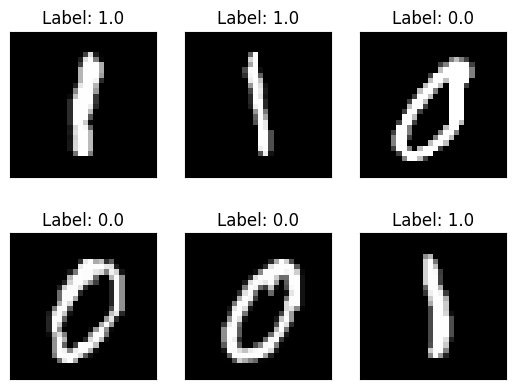

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3)
i, j = 0, 0

np.random.shuffle(X_test)

for idx, x in enumerate(X_test[:6]):

    img = x.reshape(28, 28)
    x = x.reshape(1, *x.shape)
    y_pred = model.predict(x)

    ax[i, j].imshow(img, cmap='gray')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].set_title(f'Label: {np.round(y_pred[0, 0])}')

    j += 1
    if j % 3 == 0:
        i += 1
        j = 0

plt.show()

# Visualization of kernels learned

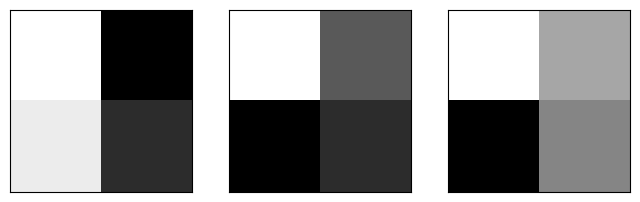

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))

conv = model.layers[0]

for i in range(conv.output_channels):
    for j in range(conv.input_channels):

        x = conv.kernels[i, j]
        ax[i].imshow(x, cmap='gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

plt.show()

# MNIST classification

In [19]:
def preprocess_whole_mnist(x):
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    return x

def one_hot_encode(y):
    categories = np.unique(y)
    encoded_y = np.zeros((len(y), len(categories)))

    for idx, label in enumerate(y):
        to_encode_idx = np.argwhere(categories == label)
        encoded_y[idx, to_encode_idx] = 1

    return encoded_y

X_train, y_train, X_test, y_test = load_mnist(path_train_data, path_train_labels, path_test_data, path_test_labels)

X_train = preprocess_whole_mnist(X_train[:1000])
X_test = preprocess_whole_mnist(X_test[:200])

y_train = one_hot_encode(y_train[:1000])
y_test = one_hot_encode(y_test[:200])

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (1000, 1, 28, 28), y_train: (1000, 10)
X_test: (200, 1, 28, 28), y_test: (200, 10)


In [20]:
from dlfs.base import Loss, Activation

class CCE_Loss(Loss):

    def calculate(self, y_pred, y_true):
        samples = range(len(y_pred))
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[samples, y_true]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        return (-np.sum(np.log(correct_confidences)))

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if(len(y_true.shape)) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples   

class Softmax(Activation):

    def forward(self, inputs):
        self.inputs = inputs
        exp = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True) 

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues) 

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            single_output = single_output.reshape(-1, 1)

            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues) 

In [21]:
layers = [ConvolutionalLayer(input_shape=(1, 28, 28), output_channels=3, kernel_size=3, stride=2, padding=1),
          MaxPoolLayer(input_shape=(3, 14, 14), kernel_size=3, stride=2, padding=2), 
          ReshapeLayer(input_shape=(3, 8, 8), output_shape=(3*8*8, )),
          DenseLayer(3*8*8, 100),
          Sigmoid(),
          DenseLayer(100, 10),
          Softmax()]

model = Model(layers=layers, loss_function=CCE_Loss(), optimizer=Optimizer_Adam(learning_rate=5e-3, decay=1e-2))

model.train(X_train, y_train, print_every=5, epochs=20)

===== EPOCH : 0 ===== LOSS : 2411.83611 =====
===== EPOCH : 5 ===== LOSS : 2131.32714 =====
===== EPOCH : 10 ===== LOSS : 1938.13058 =====
===== EPOCH : 15 ===== LOSS : 1714.83507 =====
===== EPOCH : 20 ===== LOSS : 1499.82863 =====


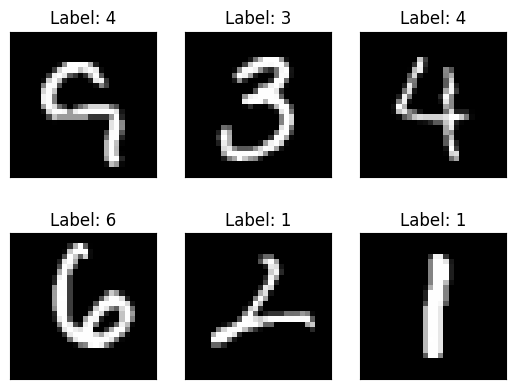

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=3)
i, j = 0, 0

np.random.shuffle(X_test)

for idx, x in enumerate(X_test[:6]):

    img = x.reshape(28, 28)
    x = x.reshape(1, *x.shape)
    y_pred = model.predict(x)

    ax[i, j].imshow(img, cmap='gray')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].set_title(f'Label: {np.argmax(y_pred.reshape(-1))}')

    j += 1
    if j % 3 == 0:
        i += 1
        j = 0

plt.show()